In [17]:
#@title

import pandas as pd
import numpy as np
from dateutil import parser
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)
from IPython.display import display

# Google API
from googleapiclient.discovery import build

In [3]:
#@title
# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
#@title


channel_ids = ['UC7cht_rw6ofX3wTirrQG8kw', # Ergo
               'UCbQ9vGfezru1YRI1zDCtTGg', # Cardano
               #'UC6rYoXJ_3BbPyWx_GQDDRRQ', Ethereum protocol
                'UCNOfzGXD_C9YMYmnefmPH0g', #EthereumFoundation
               'UCB7PbjuZLEba_znc7mEGNgw', # Polkadot
               'UC9AdQPUe4BdVJ8M9X7wxHUA', # Solana
               #'UCG9fZu6D4I83DStktBV0Ryw', #BNB
              ]

youtube = build('youtube', 'v3', developerKey=api_key)

In [5]:
#@title
def get_channel_stats(youtube, channel_ids):
 
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

def get_video_details(youtube, video_ids):
    
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

def get_comments_in_videos(youtube, video_ids):
    
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)    

In [6]:
#@title
channel_data = get_channel_stats(youtube, channel_ids)

In [7]:
#@title
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,Polkadot,48500,2916168,547,UUB7PbjuZLEba_znc7mEGNgw
1,Cardano Foundation,26000,712948,191,UUbQ9vGfezru1YRI1zDCtTGg
2,Ethereum Foundation,63900,3098368,1515,UUNOfzGXD_C9YMYmnefmPH0g
3,Solana,37600,1915532,562,UU9AdQPUe4BdVJ8M9X7wxHUA
4,Ergo Platform,6300,415651,323,UU7cht_rw6ofX3wTirrQG8kw


In [8]:
#@title
# Create a dataframe 

df = pd.DataFrame()
comments_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)
    # get comment data
    comments_data = get_comments_in_videos(youtube, video_ids)

    # append video data together and comment data toghether
    df = df.append(video_data, ignore_index=True)
    comments_df = comments_df.append(comments_data, ignore_index=True)

Getting video information from channel: Polkadot


Could not get comments for video _OltsAVp0DY


Could not get comments for video 3OmdnjyUwZ8


<ipython-input-8-8f94e1107741>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(video_data, ignore_index=True)
<ipython-input-8-8f94e1107741>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: Cardano Foundation


Could not get comments for video 4hivIWlo6GY


Could not get comments for video Q9xubdEVkUk
Could not get comments for video E7NbPnaM7ng
Could not get comments for video lq2sXYVDlX8
Could not get comments for video 2M_HLTHiWEY
Could not get comments for video 9fbOQ05zi2k
Could not get comments for video 4IJIS8AX6ag
Could not get comments for video pUaJPoozWrg
Could not get comments for video S8qEvSJq36A
Could not get comments for video RlySzj8HiaQ
Could not get comments for video HqWLe7sT_rI
Could not get comments for video X9n6cxKT0n8
Could not get comments for video FEfRXuM_w_c
Could not get comments for video o7nq-wDuY_E


Could not get comments for video CBoN9zI8kkQ
Could not get comments for video wH5JU5TQNco
Could not get comments for video -ma--vxfrq0
Could not get comments for video eu33LARo52I
Could not get comments for video nkZCs2ymojU
Could not get comments for video llJEWnW5VT0
Could not get comments for video _xbsTZNuOrw
Could not get comments for video vUJQ6oYHeFY
Could not get comments for video Wlv8ljMeGQU
Could not get comments for video t5pZmFBB91s
Could not get comments for video oSkNLSI7qIs
Could not get comments for video lY7RECQQEME
Could not get comments for video bgD2raRXF1U
Could not get comments for video HonNZUW1Zf8


Could not get comments for video 4MAaeqg9v0o
Could not get comments for video 6g57R9SQPkY
Could not get comments for video OycdoeNT-m8
Could not get comments for video cFKAtrU3jjw
Could not get comments for video huMUuhWPhvM
Could not get comments for video wGTc-Er8-S8
Could not get comments for video Ez971X24Wso
Could not get comments for video AtJj_e22rdY
Could not get comments for video G9xs7U1boIo
Could not get comments for video poZt4jVJFbM
Could not get comments for video kk47iI54pTc
Could not get comments for video Ae_KS2s4vRA


Could not get comments for video TcZY_ULuGAg
Could not get comments for video KoVW9-ctCqw
Could not get comments for video IG1JVp_zwqw
Could not get comments for video 2Sb74ztBG6o
Could not get comments for video LGhFS8jAM9A
Could not get comments for video 2AWxWixGnuk
Could not get comments for video onN3KdPnB6Q
Could not get comments for video Y3asPPJ5Tbs
Could not get comments for video LJcelO9tjtU


Could not get comments for video 3VnS-rHP6uM
Could not get comments for video 2uEQbjHmkbU
Could not get comments for video Rvzp4UsMd8I
Could not get comments for video GpaNlplqFXU
Could not get comments for video YNrEWV-n7uY
Could not get comments for video 6TnjhhDyrB4
Could not get comments for video VovfQ4fIKyw
Could not get comments for video v3Bjk7FegfM
Could not get comments for video 9jWwnqFBuaI
Could not get comments for video zvRByB1hzl4
Could not get comments for video cp5U5ACdMAg


Could not get comments for video 1t78K578eSE
Could not get comments for video Wj8deKv5PPY
Could not get comments for video iUb1xknwyPA
Could not get comments for video 90o-lty-M9g
Could not get comments for video N7eKTAoUUPs
Could not get comments for video dOJxVQQMhrI
Could not get comments for video qBi-1sPSQ8I
Could not get comments for video IO5-RttJXiA
Could not get comments for video K2PBIAr_GQM
Could not get comments for video ccIHm--6rRc


<ipython-input-8-8f94e1107741>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(video_data, ignore_index=True)
<ipython-input-8-8f94e1107741>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Could not get comments for video IYWqbr8Dq1w
Could not get comments for video _aE5yGgxApE
Could not get comments for video 5Fl5jikuZMM
Could not get comments for video BFfGbDtiEio
Could not get comments for video ZJhhk9dOF54
Could not get comments for video ecfPgjBdznk
Could not get comments for video jfv7Ha8cPps
Getting video information from channel: Ethereum Foundation


Could not get comments for video zv5E9bq34j4


Could not get comments for video qDa4xjQq1RE


<ipython-input-8-8f94e1107741>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(video_data, ignore_index=True)
<ipython-input-8-8f94e1107741>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: Solana


Could not get comments for video elgrIB1SnYg


Could not get comments for video ICXJoVGapSw


<ipython-input-8-8f94e1107741>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(video_data, ignore_index=True)
<ipython-input-8-8f94e1107741>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: Ergo Platform


<ipython-input-8-8f94e1107741>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(video_data, ignore_index=True)
<ipython-input-8-8f94e1107741>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


In [9]:
# change columns to numeric and date format

df['viewCount'] = pd.to_numeric(df['viewCount'])
df['likeCount'] = pd.to_numeric(df['likeCount'])
df['favouriteCount'] = pd.to_numeric(df['favouriteCount'])
df['commentCount'] = pd.to_numeric(df['commentCount'])
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

In [10]:
df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,_OltsAVp0DY,Polkadot,Integrations Tools Being Built and Maintained ...,"If you have any questions, reach out to the co...",None,2023-06-02 12:50:01+00:00,0,8.0,NaN,0.0,P0D,sd,false
1,kt5h_hy862Q,Polkadot,Polkadot Decoded | June 28-29 | Register Now,"Polkadot Decoded, the flagship event for the P...",None,2023-06-01 08:09:02+00:00,514,44.0,NaN,1.0,PT51S,hd,false
2,eFtWVq6dR0Y,Polkadot,Assets Pallet | Polkadot Deep Dives,"If you have any questions, reach out to the co...",None,2023-05-26 17:01:03+00:00,465,27.0,NaN,2.0,PT54M26S,hd,false
3,sgOLSdd9Kf0,Polkadot,Benchmarking Demo | Polkadot Deep Dives,"If you have any questions, reach out to the co...",None,2023-05-26 15:27:19+00:00,243,15.0,NaN,1.0,PT28M11S,hd,false
4,JGNyexOpDOI,Polkadot,Crust Network in Use!,This seminar will discuss what Crust Network i...,None,2023-05-24 03:20:14+00:00,862,59.0,NaN,4.0,PT1H6M41S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,1SrzybpblMM,Ergo Platform,Driving Mass Adoption in Blockchain - Ergo and...,Alex Chepurnoy presenting Ergo in Ho Chi Minh ...,"[Emurgo, NTFs, Technology, Dapps, Interoperabi...",2019-11-02 17:08:48+00:00,645,18.0,NaN,3.0,PT3H12M,hd,false
3138,R4ieaI6pn7M,Ergo Platform,Ergo - Seoul Meetup 2019,"Korea Crypto Social - Alex Chepurnoy, core dev...","[NTFs, Interoperability, PoS, Ergo Auction Hou...",2019-10-31 18:36:25+00:00,265,11.0,NaN,0.0,PT1M7S,sd,false
3139,g3FlM_WOwBU,Ergo Platform,Multi-Stage Contracts in the UTXO Model: Deliv...,Paper https://link.springer.com/chapter/10.100...,"[Network, Staking Pools, Ethereum, Mining, Too...",2019-09-30 16:44:16+00:00,633,21.0,NaN,0.0,PT27M11S,hd,false
3140,nrF-r_sylsU,Ergo Platform,"Genesis Block Conference, Hong Kong: Ergo, Sur...","Genesis Block Conference, Hong Kong: Taking pl...","[Blockchain, DeFi, Yoroi, Ergo, Emurgo, NTFs, ...",2019-04-02 17:13:13+00:00,528,20.0,NaN,1.0,PT52M47S,hd,false


In [11]:
comments_df

,video_id,comments
0,kt5h_hy862Q,[independence forever]
1,eFtWVq6dR0Y,[And where will it be safer to keep assets? au...
2,sgOLSdd9Kf0,[Sometimes i feel that i am most patient when ...
3,JGNyexOpDOI,"[data is gold, but ...is very expensive, they ..."
4,IG_RGLsb2g0,[Itz doin scam of peoples money. \nItz a scam ...
...,...,...
3054,1SrzybpblMM,"[Cool, Good project, Great presentation!]"
3055,R4ieaI6pn7M,[]
3056,g3FlM_WOwBU,[]
3057,nrF-r_sylsU,[Funny how i started looking into enterprise u...


In [12]:
# save as  CSV file and store it in our computer 


df.to_csv('video_data_top10_channels.csv')
comments_df.to_csv('comments_data_top10_channels.csv')

import os

video_data_path = 'video_data_top10_channels.csv'
comments_data_path = 'comments_data_top10_channels.csv'

# Get the absolute file paths
video_data_path = os.path.abspath(video_data_path)
comments_data_path = os.path.abspath(comments_data_path)

from google.colab import files

# Download the video data CSV file
files.download(video_data_path)

# Download the comments data CSV file
files.download(comments_data_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Function to convert duration to minutes
def duration_to_minutes(duration):
    minutes = pd.to_timedelta(duration).total_seconds() // 60
    seconds = pd.to_timedelta(duration).total_seconds() % 60
    return (minutes * 60 + seconds) / 60

# add columns 'duration_minutes', Comments and likes per 1000 view ratio, and titleLength
df['duration_minutes'] = df['duration'].apply(duration_to_minutes)

df['likeRatio'] = df['likeCount']/ df['viewCount'] * 1000
df['commentRatio'] = df['commentCount']/ df['viewCount'] * 1000
df['titleLength'] = df['title'].apply(lambda x: len(x))


In [14]:
df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,duration_minutes,likeRatio,commentRatio,titleLength
0,_OltsAVp0DY,Polkadot,Integrations Tools Being Built and Maintained ...,"If you have any questions, reach out to the co...",None,2023-06-02 12:50:01+00:00,0,8.0,NaN,0.0,P0D,sd,false,0.000000,inf,NaN,65
1,kt5h_hy862Q,Polkadot,Polkadot Decoded | June 28-29 | Register Now,"Polkadot Decoded, the flagship event for the P...",None,2023-06-01 08:09:02+00:00,514,44.0,NaN,1.0,PT51S,hd,false,0.850000,85.603113,1.945525,44
2,eFtWVq6dR0Y,Polkadot,Assets Pallet | Polkadot Deep Dives,"If you have any questions, reach out to the co...",None,2023-05-26 17:01:03+00:00,465,27.0,NaN,2.0,PT54M26S,hd,false,54.433333,58.064516,4.301075,35
3,sgOLSdd9Kf0,Polkadot,Benchmarking Demo | Polkadot Deep Dives,"If you have any questions, reach out to the co...",None,2023-05-26 15:27:19+00:00,243,15.0,NaN,1.0,PT28M11S,hd,false,28.183333,61.728395,4.115226,39
4,JGNyexOpDOI,Polkadot,Crust Network in Use!,This seminar will discuss what Crust Network i...,None,2023-05-24 03:20:14+00:00,862,59.0,NaN,4.0,PT1H6M41S,hd,false,66.683333,68.445476,4.640371,21


The Ergo Platform, despite having a market capitalization that is 1/2400th of Ethereum, 1/130th of Cardano, 1/70th of Polkadot, and 1/87th of Solana,  exhibits remarkable performance. It boasts the highest median number of views, standing at 839, along with the second-highest median number of likes. The utilization of the median in this context is very important to establish the base audience due to the substantial variation observed between channels due to the substantial variance observed among channels, characterized by a combination of viral videos amassing hundreds of thousands of views and others garnering considerably fewer views.

In [22]:


# Group the dataframe by 'channelTitle'
grouped = df.groupby('channelTitle')

# Specify the columns for descriptive statistics
columns = ['viewCount', 'likeCount', 'commentCount', 'likeRatio', 'commentRatio']

# Calculate descriptive statistics for each channel
channel_stats = grouped[columns].describe()

# Display the entire statistics table
print(channel_stats.to_string())


                    viewCount                                                                     likeCount                                                           commentCount                                                    likeRatio                                                                               commentRatio                                                                      
                        count         mean           std    min     25%    50%      75%       max     count        mean         std  min    25%   50%     75%     max        count       mean        std  min  25%  50%   75%     max     count       mean        std       min        25%        50%         75%         max        count       mean        std  min       25%       50%        75%         max
channelTitle                                                                                                                                                                                          

The correlation matrix for all channels shows no correlation, however filtering by channel later we can see that there is an evident correlation between views, comments and likes except on Ethereum, which is the channel that also has the most videos.

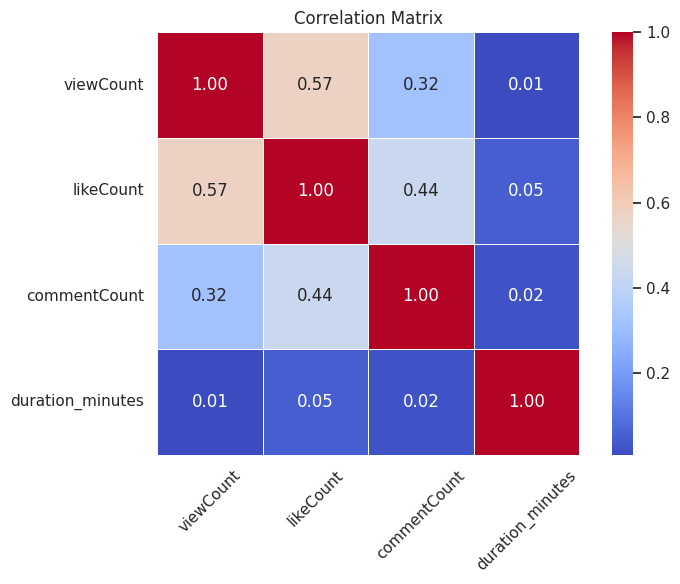

In [23]:
# Calculate the correlation matrix
correlation_matrix = df[['viewCount', 'likeCount', 'commentCount', 'duration_minutes']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, square=True)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

It is observed that there is a great correlation between comments, likes and views in most of the channels except ethereum.
While the correlation between views and likes exists on all channels, it is on Ethereum where it is strongest and a bit weaker on the other channels.

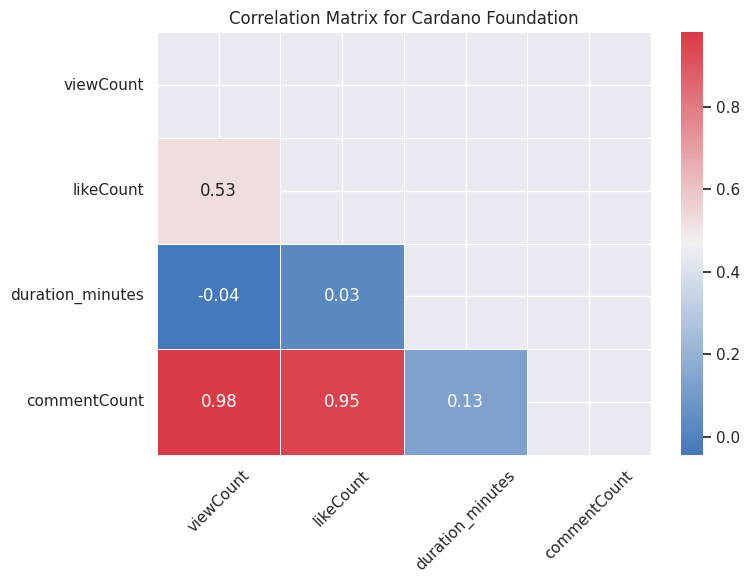

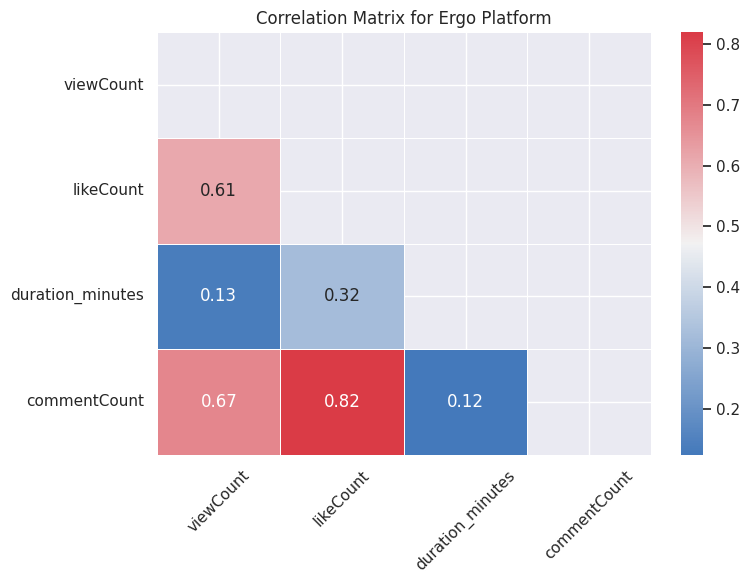

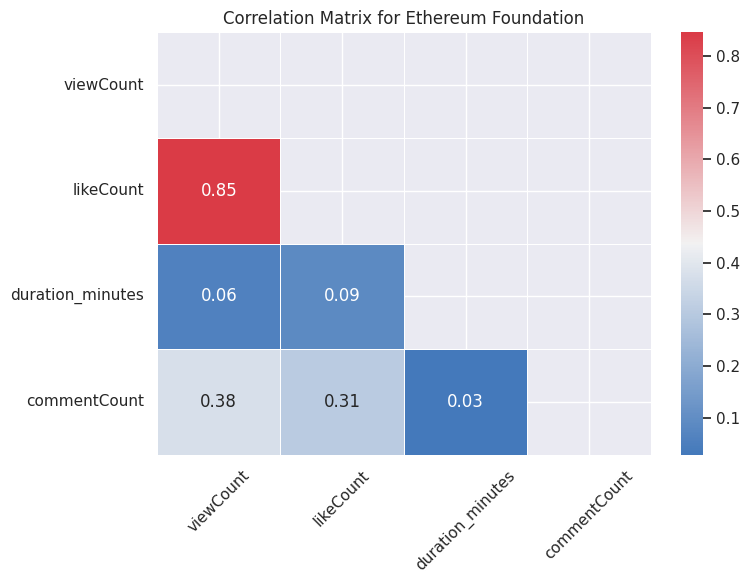

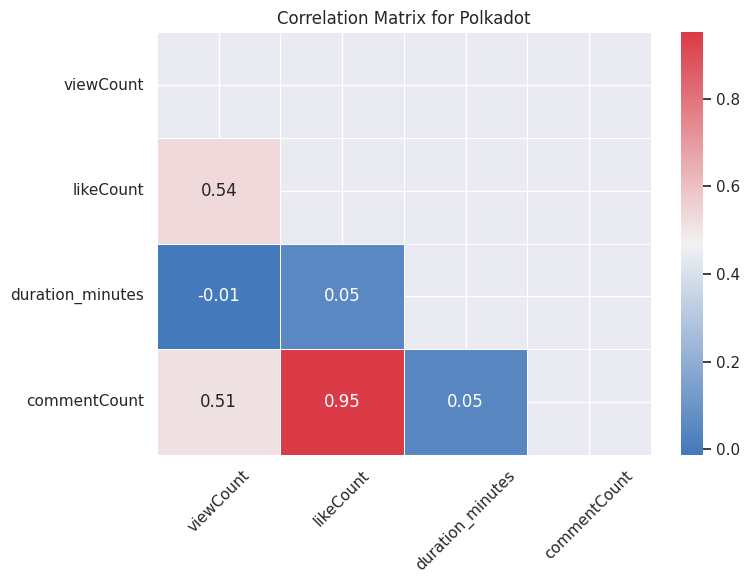

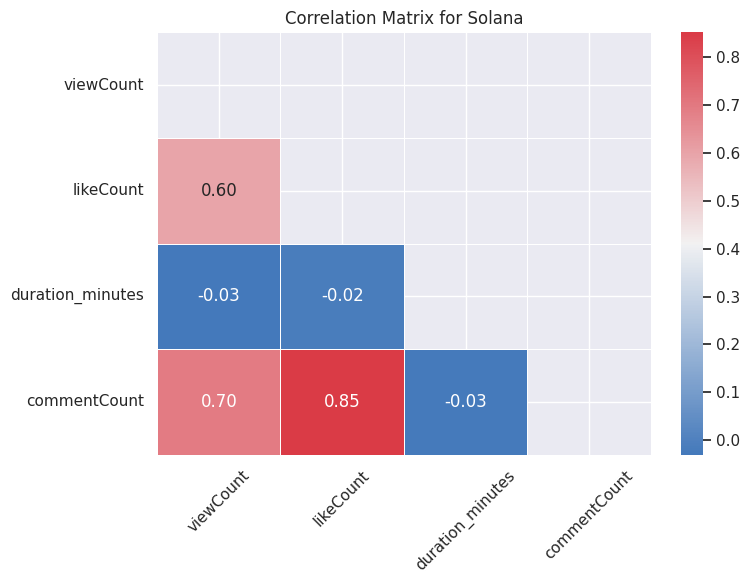

In [ ]:
# Group the DataFrame by 'channelTitle'
grouped_df = df.groupby('channelTitle')

# Iterate over each group
for title, group in grouped_df:
    # Select the desired columns for correlation calculation
    selected_cols = group[['viewCount', 'likeCount', 'duration_minutes', 'commentCount']]
    
    # Calculate the correlation matrix
    corr_matrix = selected_cols.corr()
    
    
    
    # Plotting the correlation matrix
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask to hide upper triangle
    cmap = sns.diverging_palette(250, 10, as_cmap=True)  # Colormap for better visualization

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap=cmap, cbar=True, linewidths=0.5)
    plt.title(f"Correlation Matrix for {title}")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In the graphs below we can see views over time excluding outliers, there is a downtrend on  all channels. A logical explanation is the systematic and continuous fall in market prices, highly correlated with people's interest in crypto markets.

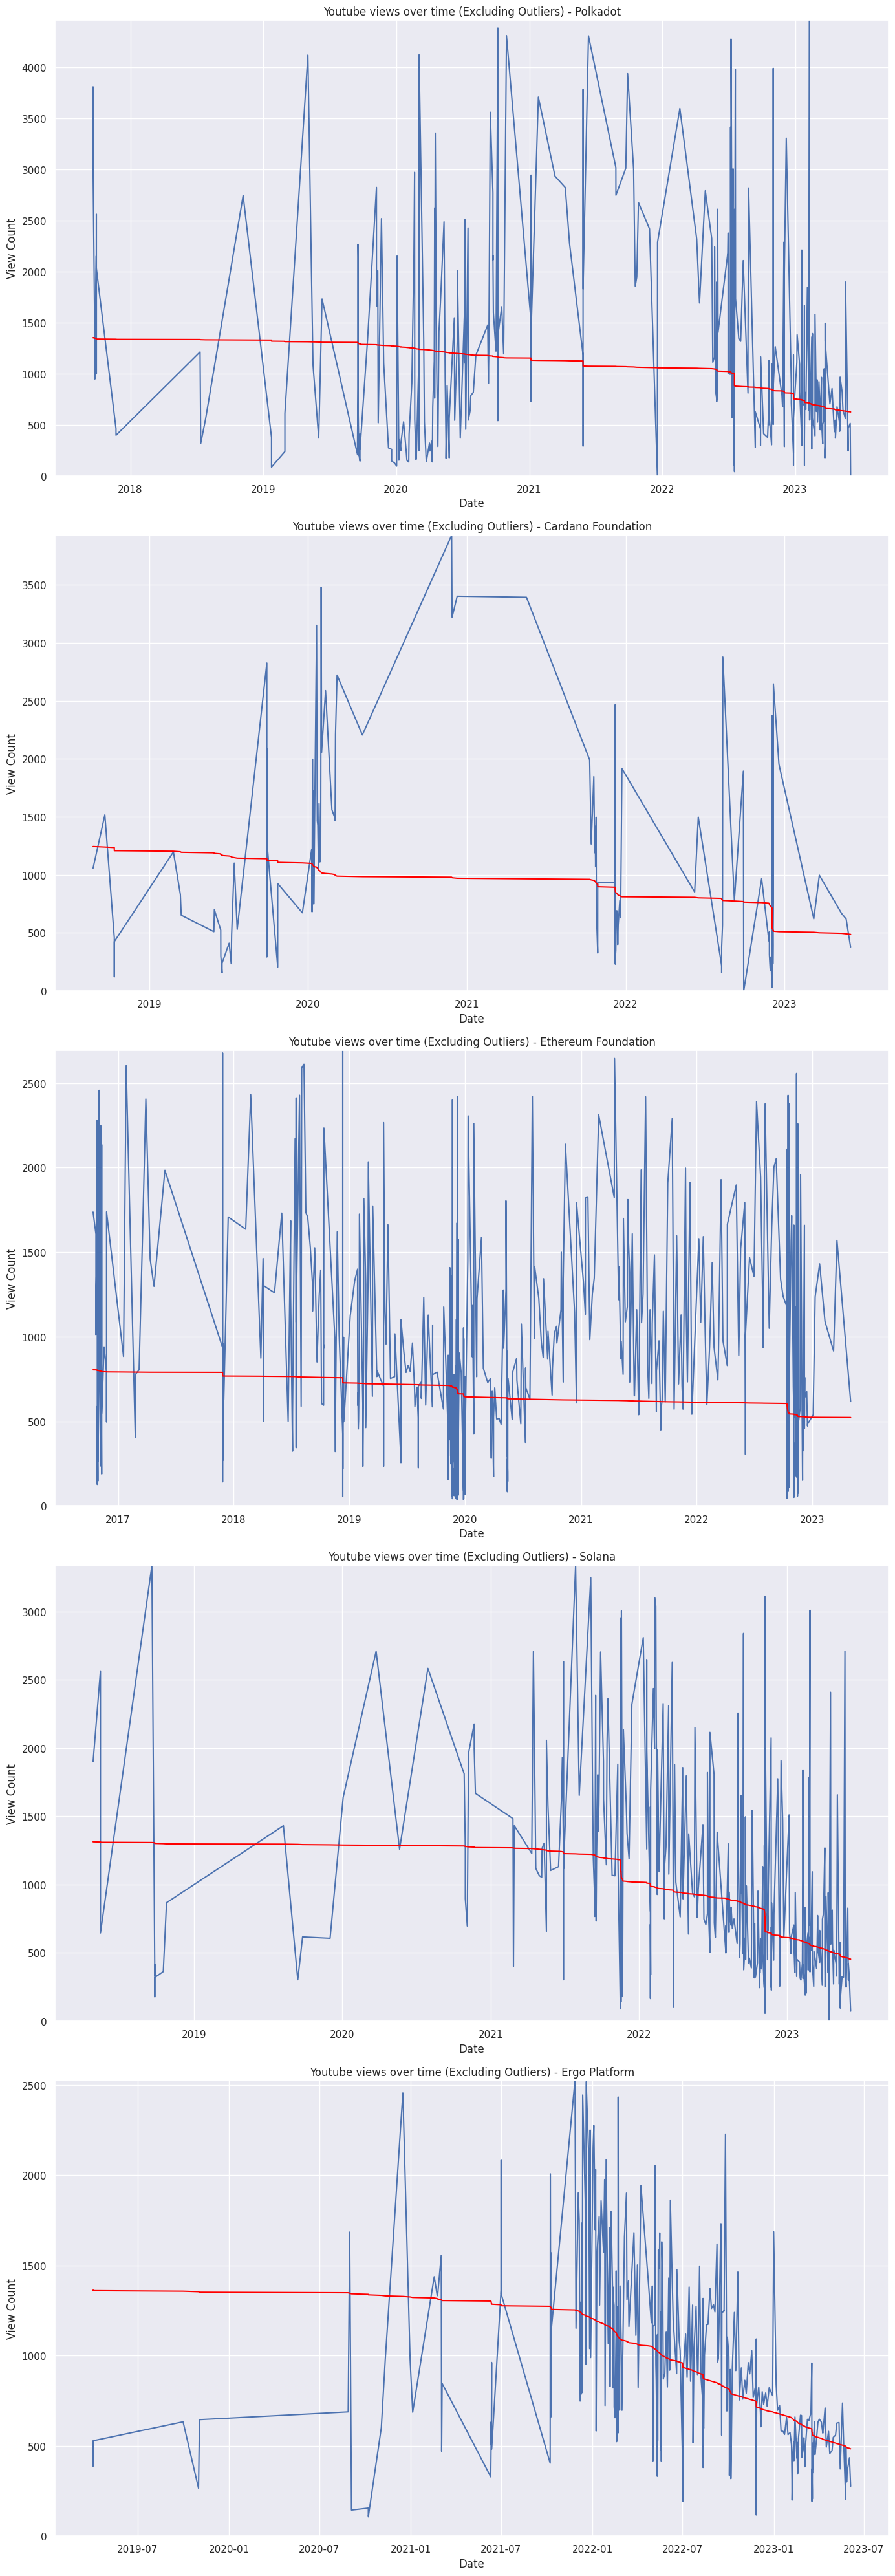

In [24]:
from sklearn.linear_model import LinearRegression

# Get unique channel titles
channel_titles = df['channelTitle'].unique()

# Plotting
fig, axs = plt.subplots(len(channel_titles), figsize=(14, 8*len(channel_titles)))

for i, title in enumerate(channel_titles):
    # Filter the DataFrame based on 'channelTitle'
    filtered_df = df[df['channelTitle'] == title]

    # Calculate the IQR for 'viewCount'
    q1 = filtered_df['viewCount'].quantile(0.25)
    q3 = filtered_df['viewCount'].quantile(0.75)
    iqr = q3 - q1

    # Set the lower and upper bounds to filter outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Filter outliers
    filtered_df = filtered_df[(filtered_df['viewCount'] >= lower_bound) & (filtered_df['viewCount'] <= upper_bound)]

    # Plotting for each channel title
    axs[i].plot(filtered_df['publishedAt'], filtered_df['viewCount'])
    axs[i].set_title(f'Youtube views over time (Excluding Outliers) - {title}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('View Count')
    axs[i].set_ylim(0, filtered_df['viewCount'].max())
    axs[i].grid(True)

    # Add trend line
    x = np.arange(len(filtered_df['publishedAt'])).reshape(-1, 1)
    y = filtered_df['viewCount'].values.reshape(-1, 1)
    reg = LinearRegression().fit(x, y)
    trend = reg.predict(x)
    axs[i].plot(filtered_df['publishedAt'], trend, color='red')

plt.tight_layout()
plt.show()

With the  violin plot we can reaffirm how the Ergo platform has one of the most solid base audiences, with the distribution of videos relatively stable in terms of total reproductions, the negative part is that unlike other channels it doesn't have as many viral videos as these, which would potentially allow it to capture more market.


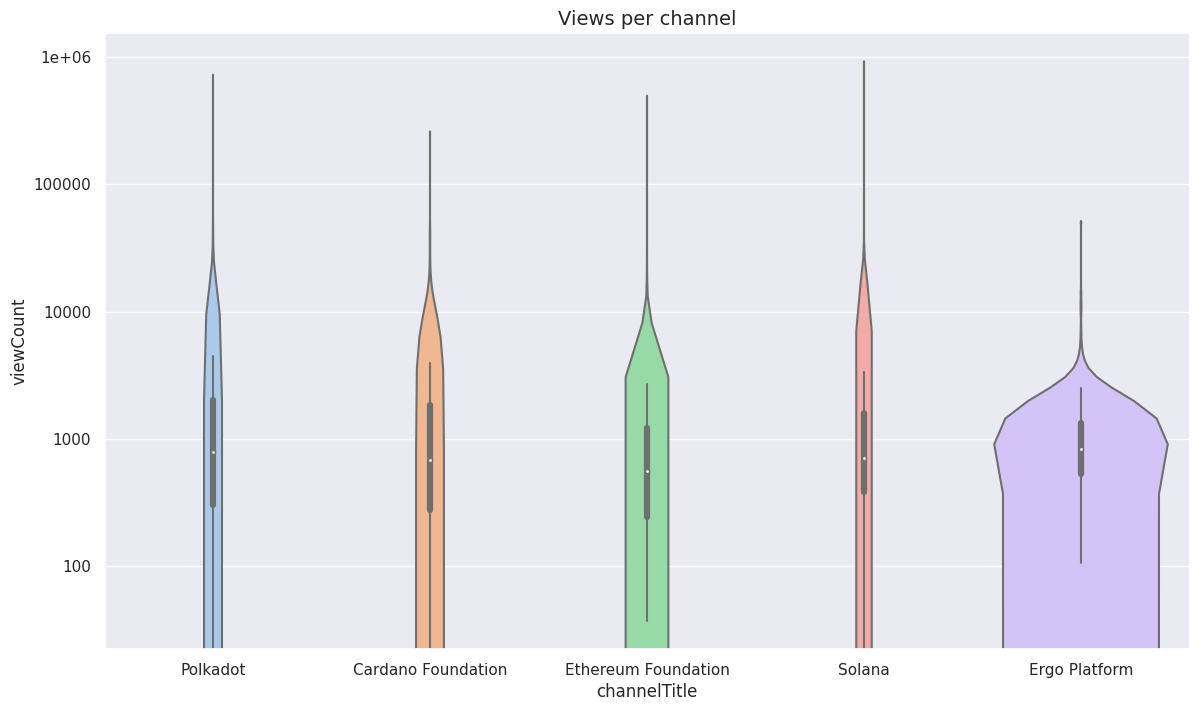

In [25]:
plt.rcParams['figure.figsize'] = (14, 8)

sns.violinplot(x=df['channelTitle'], y=df['viewCount'], palette='pastel')
plt.title('Views per channel', fontsize=14)

plt.yscale('log')


# Format y-axis ticks to display actual numbers
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

plt.show()

As we saw above, in general, all channels show a correlation between comments and likes, people who comment are more likely to leave likes and vice versa.

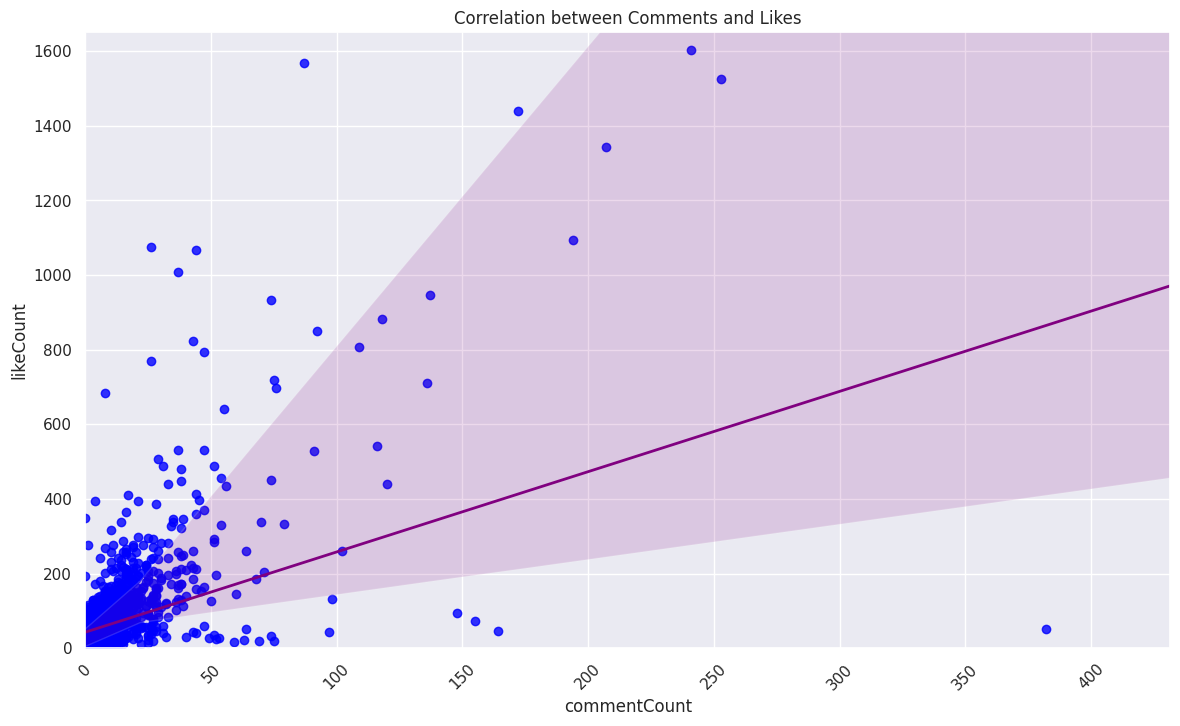

In [26]:
plt.figure(figsize=(14, 8))
sns.regplot(x=df['commentCount'], y=df['likeCount'], line_kws={"color": "purple", "linewidth": 2}, scatter_kws={"color": "blue"})
plt.title('Correlation between Comments and Likes')
plt.xlabel('commentCount')
plt.ylabel('likeCount')
plt.xticks(rotation=45)
plt.xlim(0, df['commentCount'].max()/5)
plt.ylim(0, df['likeCount'].max()/5)
plt.grid(True)
plt.show()

It can be seen from the distribution of videos that the vast majority last between 0-5 minutes and between 15-20

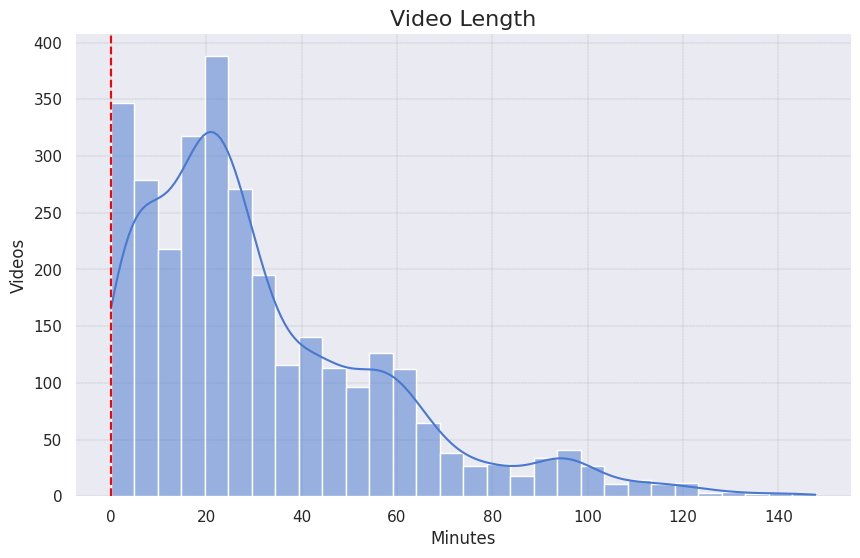

In [27]:
from matplotlib.animation import FuncAnimation

# Filter the DataFrame based on the condition 'duration_minutes < 220'
filtered_df = df[df['duration_minutes'] < 150]

# Create a custom color palette
colors = sns.color_palette('muted')

# Create the histogram plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=filtered_df, x="duration_minutes", bins=30, kde=True, color=colors[0], ax=ax)

# Set the background style
sns.set_style("whitegrid")

# red line
red_line = ax.axvline(0, color='red', linestyle='--')



# Customize the plot aesthetics
ax.set_title("Video Length", fontsize=16)
ax.set_xlabel("Minutes", fontsize=12)
ax.set_ylabel("Videos", fontsize=12)
sns.despine(left=True, bottom=True)
ax.grid(color='gray', linestyle='--', linewidth=0.2)

# Show the plot
plt.show()

Also there is no correlation between length of the Title and views

<Axes: xlabel='titleLength', ylabel='viewCount'>

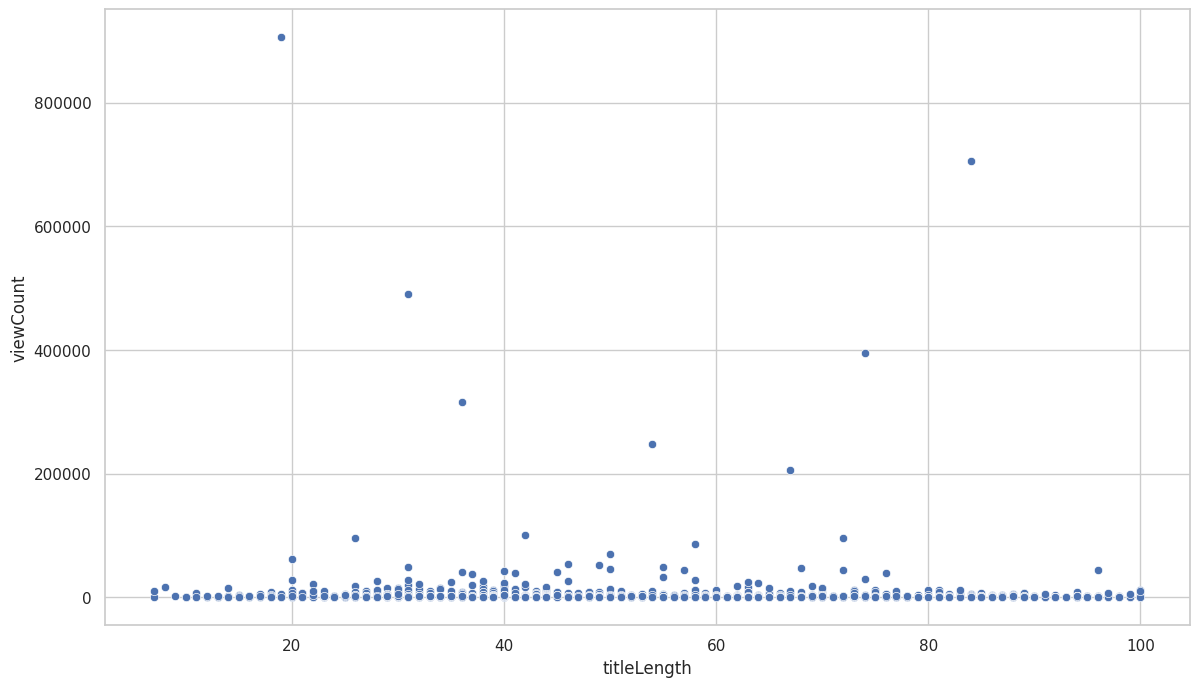

In [30]:
sns.scatterplot(data = df, x = "titleLength", y = "viewCount")


Ploting duration against comments and likes. It can be seen that  shorter videos tend to get more likes and comments than very long videos. This could also be explained because there are a lot more shorter videos than longer videos. So shorter videos are more optimal in the amount of work required vs views and likes.

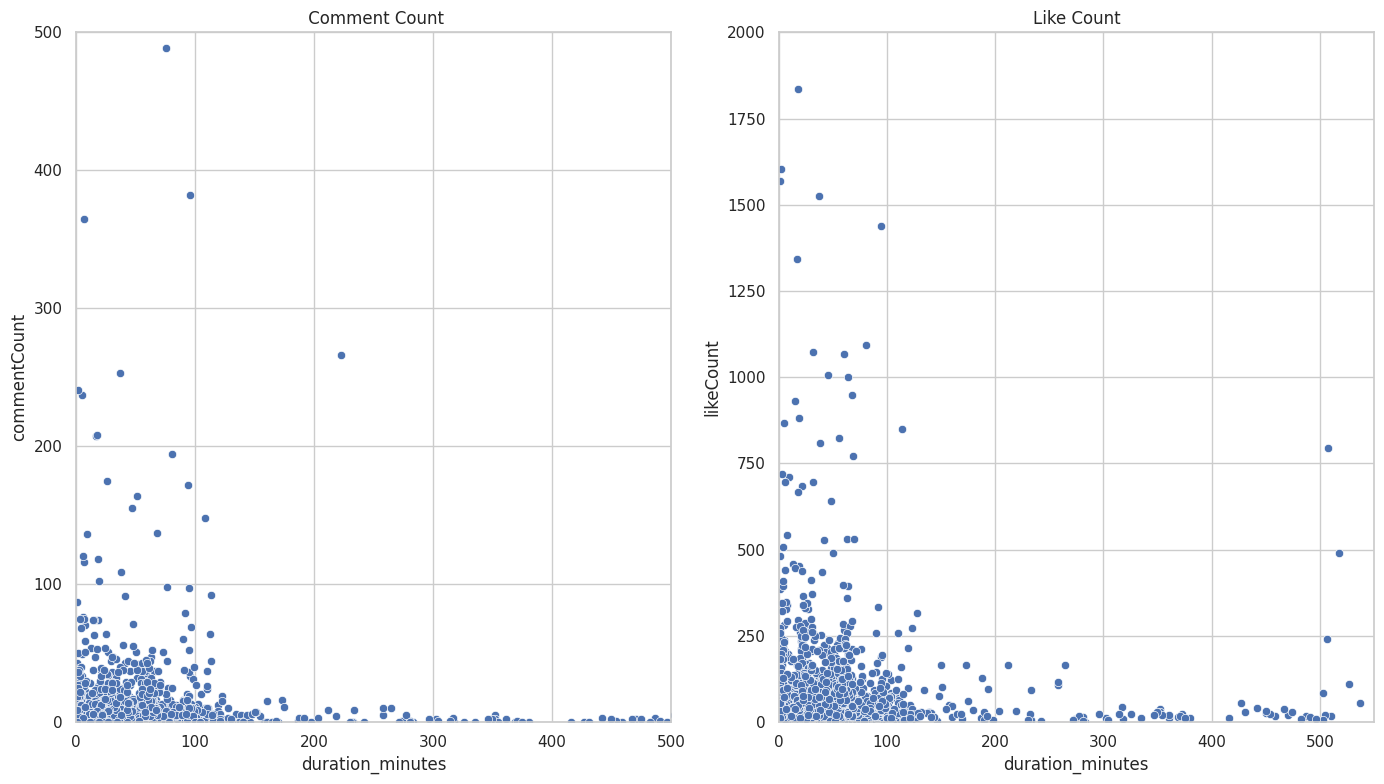

In [31]:

fig, ax = plt.subplots(1, 2)

# Scatter plot 1
sns.scatterplot(data=df, x="duration_minutes", y="commentCount", ax=ax[0])
ax[0].set_xlim(0, 500)  # Set x-axis limits
ax[0].set_ylim(0, 500)  # Set y-axis limits
ax[0].set_title(" Comment Count")

# Scatter plot 2
sns.scatterplot(data=df, x="duration_minutes", y="likeCount", ax=ax[1])
ax[1].set_xlim(0, 550)  # Set x-axis limits
ax[1].set_ylim(0, 2000)  # Set y-axis limits
ax[1].set_title("Like Count")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


<Axes: xlabel='likeRatio', ylabel='viewCount'>

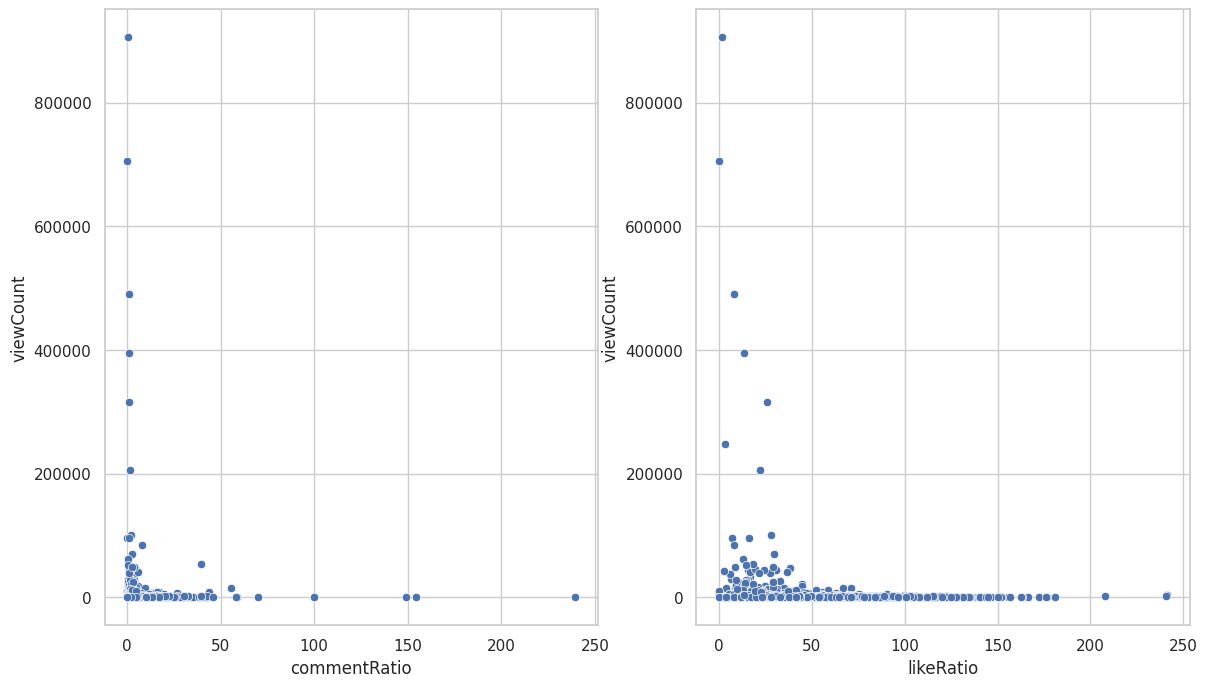

In [32]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = df, x = "likeRatio", y = "viewCount", ax=ax[1])

Wordcloud: most common words in video titles for all channels

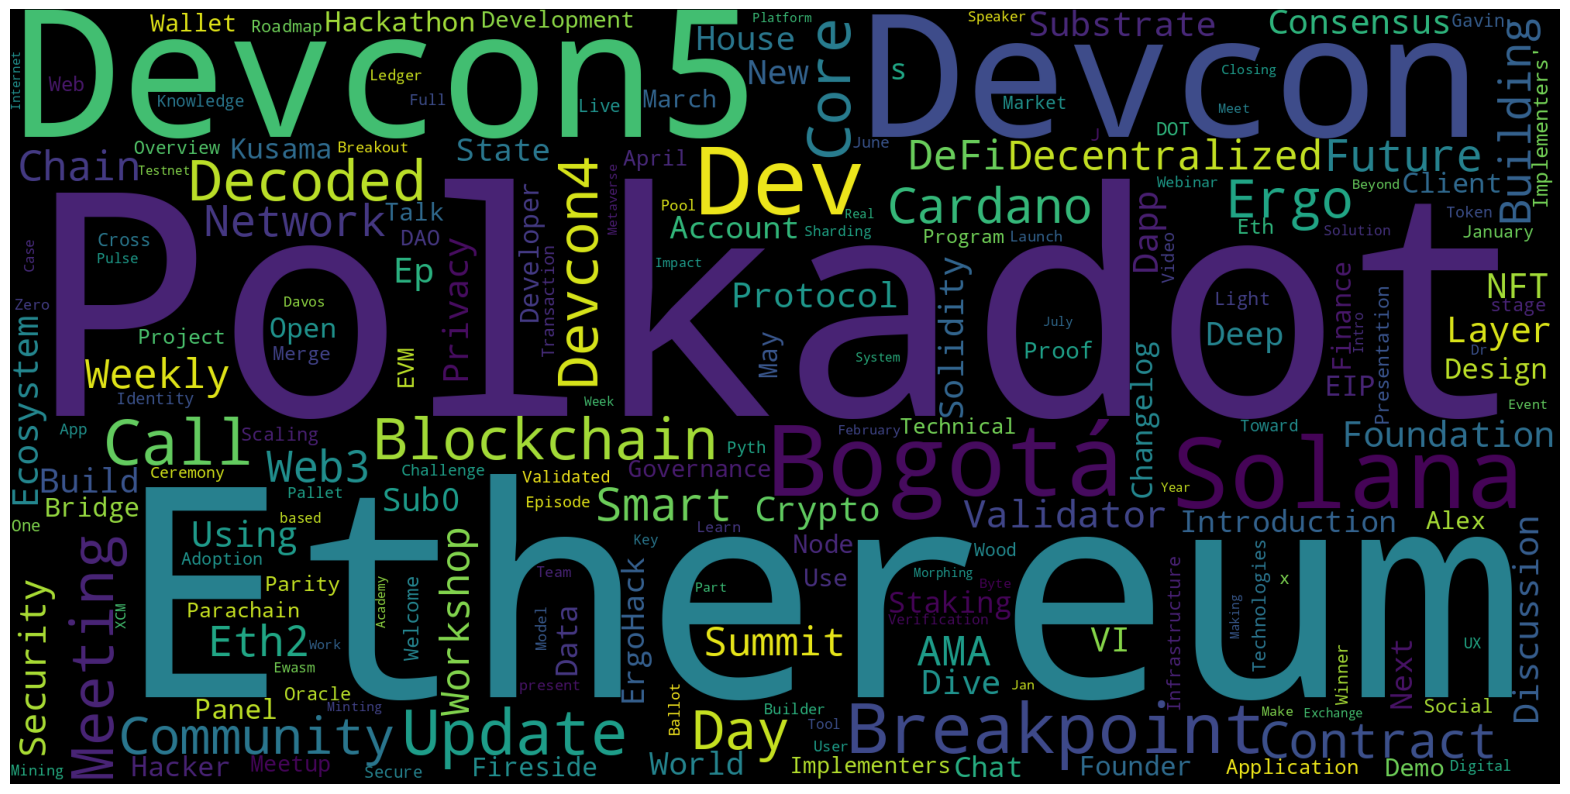

In [48]:
stop_words = set(stopwords.words('english'))
df['title_no_stopwords'] = df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(20, 12))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

Most common words in titles, just for Ergo Platform

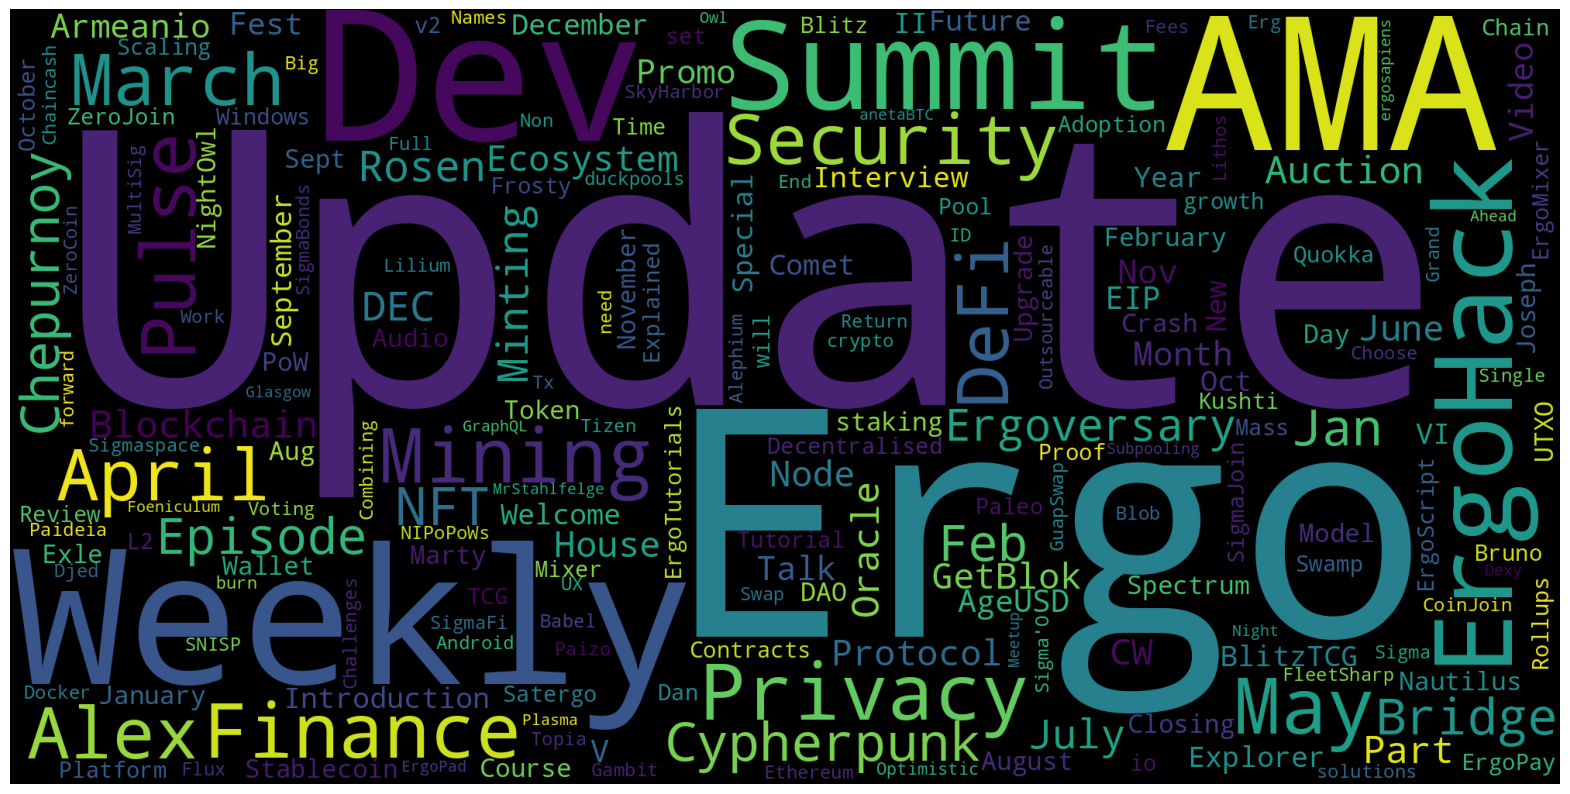

In [50]:
# Define the words to be excluded
exclude_words = []

# Function to filter out the excluded words
def filter_words(words):
    return [word for word in words if word not in exclude_words]

# Filter the dataframe for 'channelTitle' equal to 'Ergo Platform'
ergo_df = df[df['channelTitle'] == 'Ergo Platform'].copy()  # Make a copy of the filtered dataframe

# Apply stop words and filtering to the title column
ergo_df.loc[:, 'title_no_stopwords'] = ergo_df['title'].apply(lambda x: filter_words(str(x).split()))

# Concatenate all words into a single string
all_words = list([a for b in ergo_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

# Define the plot_cloud function
def plot_cloud(wordcloud):
    plt.figure(figsize=(20, 12))
    plt.imshow(wordcloud)
    plt.axis("off")

# Generate the word cloud
wordcloud = WordCloud(width=2000, height=1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(all_words_str)

# Plot the word cloud
plot_cloud(wordcloud)